In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # for gradient warning (variables are still updated, therefore supressing is fine)
import tensorflow_probability as tfp 
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.losses import Loss

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

color_list = ['#bcad', '#dacb']

### Define the dataset 

(-2.0, 2.0)

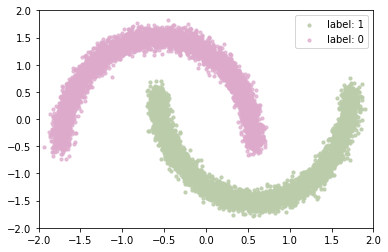

In [2]:
np.random.seed(42)

n_samples = 10000
niosy_moons = make_moons(n_samples=n_samples, noise=.05)
X, y = niosy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

y_label = y.astype(np.bool)
X_train, Y_train = X_data[...,0], X_data[...,1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color=color_list[0])
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color=color_list[1])
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

### Define prior distribution

In [3]:
def get_prior(num_modes, latent_dim):
    
    mixture_distribution = tfd.Categorical(probs=[1./num_modes] * num_modes)
    components_distribution = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal((num_modes, latent_dim))),
                                                        scale_diag=tfp.util.TransformedVariable(tf.ones((num_modes,latent_dim)),
                                                                                               bijector=tfb.Softplus())
                                                        )
    prior = tfd.MixtureSameFamily(mixture_distribution,
                                  components_distribution
                                 )
    return prior

In [4]:
latent_dim = 2
input_shape = 2

prior = get_prior(num_modes=latent_dim, latent_dim=latent_dim) 
print(f'Prior event shape: {prior.event_shape[0]}')
print(f'# of Gaussions: {prior.components_distribution.batch_shape[0]}') 
print(f'Covariance matrix: {prior.components_distribution.name}')

Prior event shape: 2
# of Gaussions: 2
Covariance matrix: MultivariateNormalDiag


### Define KL divergence

In [5]:
# set weight for more emphasis on KLDivergence term rather than reconstruction loss
# average over both samples and batches

def get_KL_regularizer(prior, weight=4.):
    
    regularizer = tfpl.KLDivergenceRegularizer(prior, 
                                        use_exact_kl=False,
                                        test_points_reduce_axis=(),
                                        test_points_fn=lambda q: q.sample(10),
                                        weight=weight
                                        )
    return regularizer

In [6]:
KLDivergence_regularizer = get_KL_regularizer(prior)

### Define the encoder

In [7]:
def get_encoder(input_shape, latent_dim, KL_regularizer):
    
    encoder = Sequential([
        Dense(input_shape=input_shape, units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, 
                                   activity_regularizer=KL_regularizer),
    ])
    
    return encoder

In [8]:
encoder = get_encoder(input_shape=(2,), latent_dim=latent_dim, KL_regularizer=KLDivergence_regularizer)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  8         
Total params: 44,173
Trainable params: 44,173
Non-trainable params: 0
____________________________________________________

### Define the decoder 

In [9]:
def get_decoder(latent_dim):
    
    decoder = Sequential([
        Dense(input_shape=(latent_dim,), units=5, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim)
    ])
    
    return decoder

In [10]:
decoder = get_decoder(latent_dim)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
_________________________________________________________________
multivariate_normal_tri_l_1  multiple                  0         
Total params: 43,028
Trainable params: 43,028
Non-trainable params: 0
__________________________________________________

### Connect encoder to decoder 

In [11]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  8     

### Specify the loss function 

In [12]:
# KL divergence is implicity incorporated to the loss function before
# add reconstruction error to loss function 
def reconstruction_error(decoding_dist, x_true):
    return -tf.reduce_mean(decoding_dist.log_prob(x_true))

class custom_reconstruction_error(Loss):
    def call(self, decoding_dist, x_true):
        return -tf.reduce_mean(decoding_dist.log_prob(x_true))

### Define training and validation sets

In [13]:
split = .75
X_train = X_data[:int(split*n_samples)]
X_test = X_data[int(split*n_samples):]
y_label_test = y_label[int(split*n_samples):]
y_label_train = y_label[:int(split*n_samples)]
print(f'# of training samples: {X_train.shape[0]}')
print(f'# of test samples: {X_test.shape[0]}')

# of training samples: 7500
# of test samples: 2500


### Visualize validation set

(-2.0, 2.0)

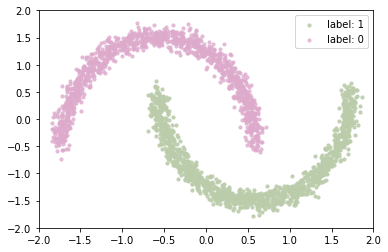

In [14]:
X_valid, Y_valid = X_test[...,0], X_test[...,1]
plt.scatter(X_valid[y_label_test], Y_valid[y_label_test], s=10, color=color_list[0])
plt.scatter(X_valid[y_label_test == False], Y_valid[y_label_test == False], s=10, color=color_list[1])
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

### Compile and fit the model 

In [15]:
optimizer = Adam(learning_rate=3e-4)
epochs = 100 
epoch_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print('\n Epoch {}/{}'.format(epoch+1, epochs, logs),
                                                                       '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                if epoch % 50 == 0 else False
                               )


vae.compile(optimizer=optimizer, loss=reconstruction_error)
history = vae.fit(X_train, 
                  validation_data=(X_test,),
                  epochs=epochs, 
                  batch_size=32,
                  verbose=0,
                  shuffle=True,
                  callbacks=[epoch_callback]
                 )


 Epoch 1/100 
	 loss: 4.3592, val_loss: 0.7423

 Epoch 51/100 
	 loss: 0.0357, val_loss: 0.0186


### Plot training and validation losses 

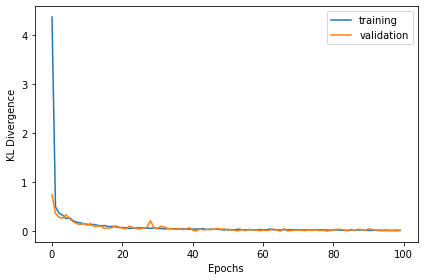

In [16]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.tight_layout()
plt.show()

# Loss function is ELBO maximization
# ELBO maximization is proportional to KL divergence minimization 

### Sample and reconstruct from the generative model

In [41]:
my_sample = np.concatenate((X_valid, Y_valid)).reshape(2, -1).transpose()
sampled = encoder(my_sample).sample()
reconstructed = decoder(sampled).sample()

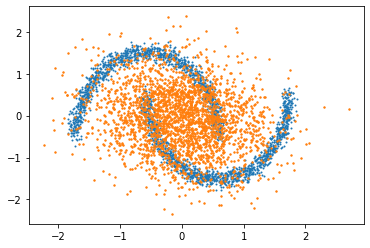

In [43]:
plt.scatter(my_sample[...,0], my_sample[..., 1], label='sampled', s=1)
plt.scatter(reconstructed[..., 0], reconstructed[..., 1], label='reconstructed', s=2)
plt.show()

## not the best looking figure 
## for a simple configuration, captures the curvature of data well 